<a href="https://colab.research.google.com/github/Marwa-Chouhdary/Data-Science-Projects/blob/main/Titanic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

##Load the Data

In [40]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")


##Explore the Data

In [41]:
print(train_df.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [42]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [43]:
print(train_df.describe())


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


<Axes: xlabel='Survived', ylabel='count'>

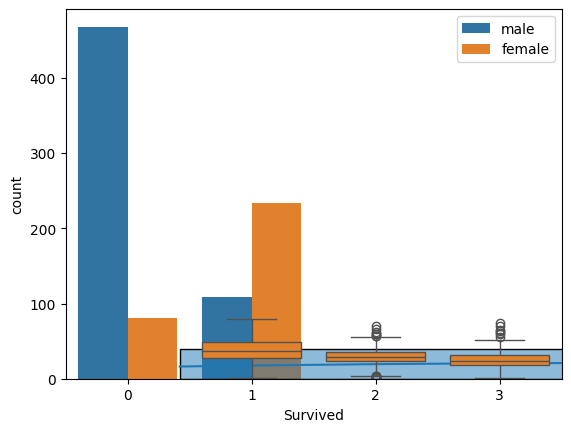

In [44]:
sns.countplot(x='Survived', data=train_df, hue='Sex')
sns.histplot(train_df['Age'].dropna(), kde=True)
sns.boxplot(x='Pclass', y='Age', data=train_df)

##Preprocess the Data

###Handle missing values:

In [45]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])


###Drop Irrelevant Features:

In [46]:
train_df.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test_df.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

###Encode categorical variables:

In [47]:
label_enc = LabelEncoder()
train_df['Sex'] = label_enc.fit_transform(train_df['Sex'])
test_df['Sex'] = label_enc.transform(test_df['Sex'])

train_df['Embarked'] = label_enc.fit_transform(train_df['Embarked'])
test_df['Embarked'] = label_enc.transform(test_df['Embarked'])

##Feature Engineering

In [48]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5, labels=False)
test_df['AgeBand'] = pd.cut(test_df['Age'], 5, labels=False)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4, labels=False)
test_df['FareBand'] = pd.qcut(test_df['Fare'], 4, labels=False)

##Feature Selection

In [49]:
features = ['Pclass', 'Sex', 'AgeBand', 'FareBand', 'Embarked', 'FamilySize', 'IsAlone']
X = train_df[features]
y = train_df['Survived']
X_test_final = test_df[features]

##Feature Scaling

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

##Train-Test Split

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


##Train Logistic Regression Model

In [52]:
# Train Logistic Regression with Tuning
model = LogisticRegression(C=0.1, max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=200)

In [53]:
# Evaluate on Validation Set
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.8100558659217877
Confusion Matrix:
 [[92 13]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [54]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.7890151277383717


##Predict on Test Set

In [55]:
test_preds = model.predict(X_test_scaled)
# Prepare submission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file created: submission.csv")

✅ Submission file created: submission.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
